In [ ]:
import time

from chanlun import kcharts
from chanlun.cl_utils import query_cl_chart_config
from chanlun.exchange import get_exchange, Market
from chanlun.exchange.exchange_db import ExchangeDB
from chanlun import cl
from chanlun.xuangu import xuangu
import itertools
import talib
from chanlun.cl_utils import *
from chanlun.cl_interface import Config

market = 'a'
start_date = '2025-01-09 09:31:00'
end_date = '2025-02-21 13:30:00'
frequencys = ['1m']

ex = ExchangeDB(market) # 读取数据库中的k线数据

In [ ]:
zhishu = [
    "SHSE.000001",  # 上证指数
    "SHSE.000016",  # 上证50
    "SHSE.000300",  # 沪深300
    "SZSE.399001",  # 深圳指数
    "SHSE.000905",  # 中证500
    "SHSE.000852",  # 中证1000
    "SZSE.399006",  # 创业板指
    "SHSE.000688",  # 科创50
    "SHSE.000044",  # 上证中盘
    "SZSE.399330", # 深圳100
    "SZSE.399935", #800信息
    "SHSE.000070", #能源等权
    "SZSE.399673", #创业板50
    "SZSE.399975", #证券公司
    "SHSE.000025", #180基建
    "SHSE.000914", #300金融
    "SHSE.000300",
]

In [ ]:
renders = []
zhishu_klines = {}
for code in zhishu:
    cl_config = query_cl_chart_config(market, code)
    print(cl_config)
    for f in frequencys:
        cl_datas = []
        klines = ex.klines(code, frequency=frequencys, start_date=start_date, end_date=end_date, args={"limit":9999})
        klines = klines[:]
        zhishu_klines[code]=klines
        print(klines[:].head(1))
        print(klines[:].tail(1))
        print(f, '获取K线数据量：', len(klines))
        _s = time.time()
        cl_datas.append(cl.CL(code, f, cl_config).process_klines(klines[:]))
        print('Run time: ', time.time() - _s)

for cd in cl_datas:
    title = '%s - 【%s】 周期数据图表' % (code, cd.frequency)
    renders.append(kcharts.render_charts(title, cd))

In [ ]:
print(klines)

In [ ]:
# 假设 zhishu_klines 已经包含每只股票的K线数据
# zhishu_klines = {...}

# 计算每只股票的5日均线
ma_period = 5
ma_data = {}

for code, klines in zhishu_klines.items():
    # 处理 NaT 值
    klines = klines.dropna(subset=['date'])
    klines['MA_5'] = talib.SMA(klines['close'], timeperiod=ma_period)
    ma_data[code] = klines[['date', 'MA_5']]

# 合并所有股票的5日均线数据
merged_ma_data = pd.concat(ma_data.values(), keys=ma_data.keys(), axis=1)

# 重命名列以便于绘制
merged_ma_data.columns = [f'{code}_{col}' for code, col in merged_ma_data.columns]

# 打印前几行以检查数据
print(merged_ma_data.head())

In [ ]:
merged_ma_data

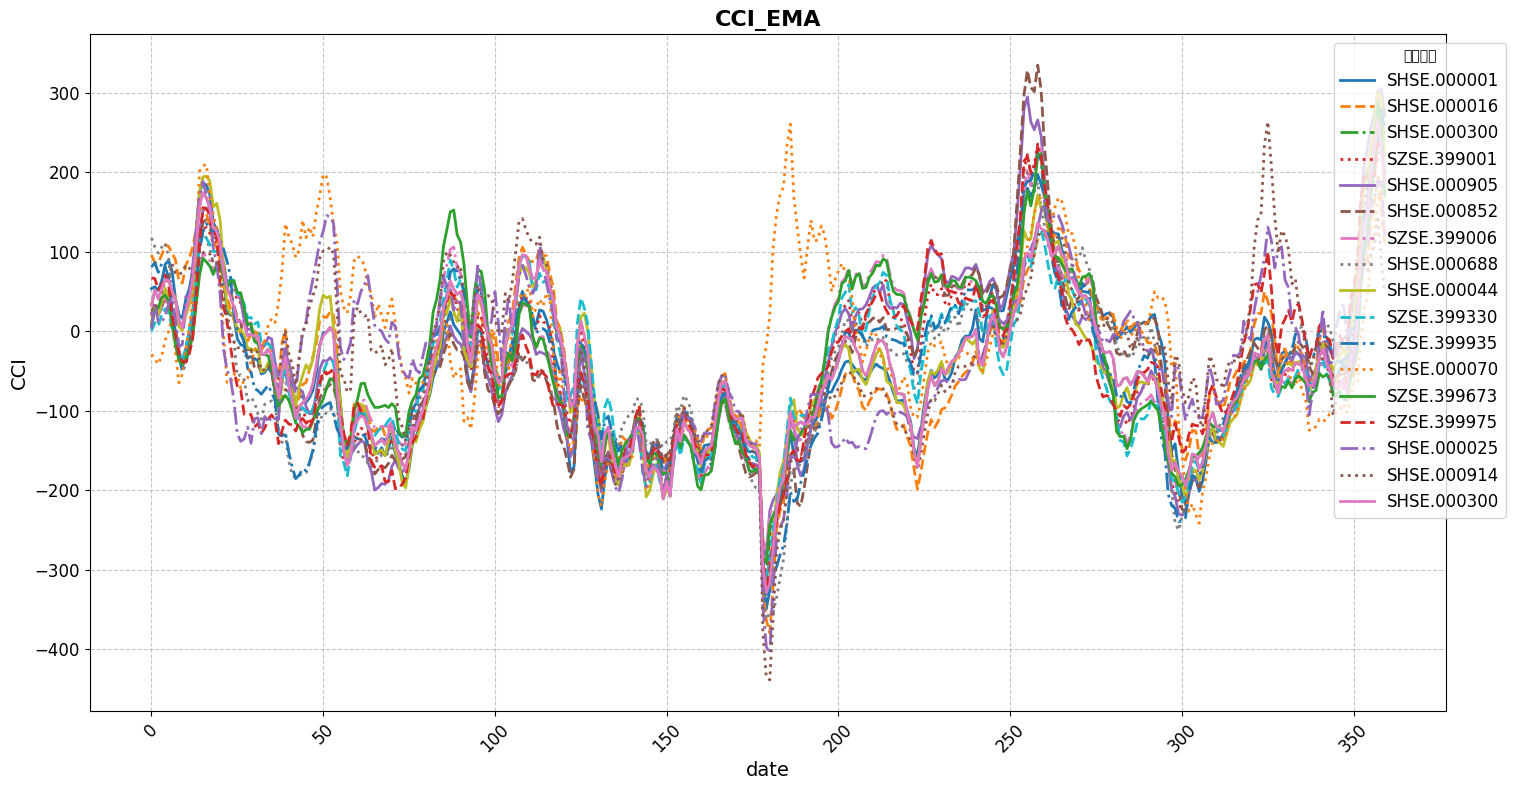

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import talib
import numpy as np

# 假设 all_indicators 已经包含所有股票的指标数据
# all_indicators = {...}

# 定义颜色和线型
colors = plt.cm.tab10.colors  # 使用tab10颜色映射
linestyles = ['-', '--', '-.', ':']  # 定义线型

plt.figure(figsize=(16, 8))

# 获取所有股票的日期范围
all_dates = pd.concat([all_indicators[f'df_{i}_date'] for i in range(17)]).drop_duplicates().sort_values()

for i in range(17):
    code = zhishu[i % len(zhishu)]  # 确保代码在 zhishu 列表中循环
    # 确保日期列被识别为时间戳
    all_indicators[f'df_{i}_date'] = pd.to_datetime(all_indicators[f'df_{i}_date'])
    
    # 过滤掉没有数据的日期
    valid_dates = all_indicators[f'df_{i}_date']
    valid_cci = all_indicators[f'df_{i}_CCI_EMA']
    
    # 确保日期和CCI数据长度一致
    valid_dates, valid_cci = valid_dates[300:660], valid_cci[300:660]
    
    index_date = [_ for _ in range(len(valid_dates))] 
    # print(len(valid_dates))
    # print(len(index_date))
    # print(len(valid_cci))
    plt.plot(
        index_date, 
        valid_cci, 
        label=code,
        color=colors[i % len(colors)],
        linestyle=linestyles[i % len(linestyles)],
        linewidth=2
    )

plt.title('CCI_EMA', fontsize=16, fontweight='bold')
plt.xlabel('date', fontsize=14)
plt.ylabel('CCI', fontsize=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1), title='股票代码', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

In [ ]:
all_indicators

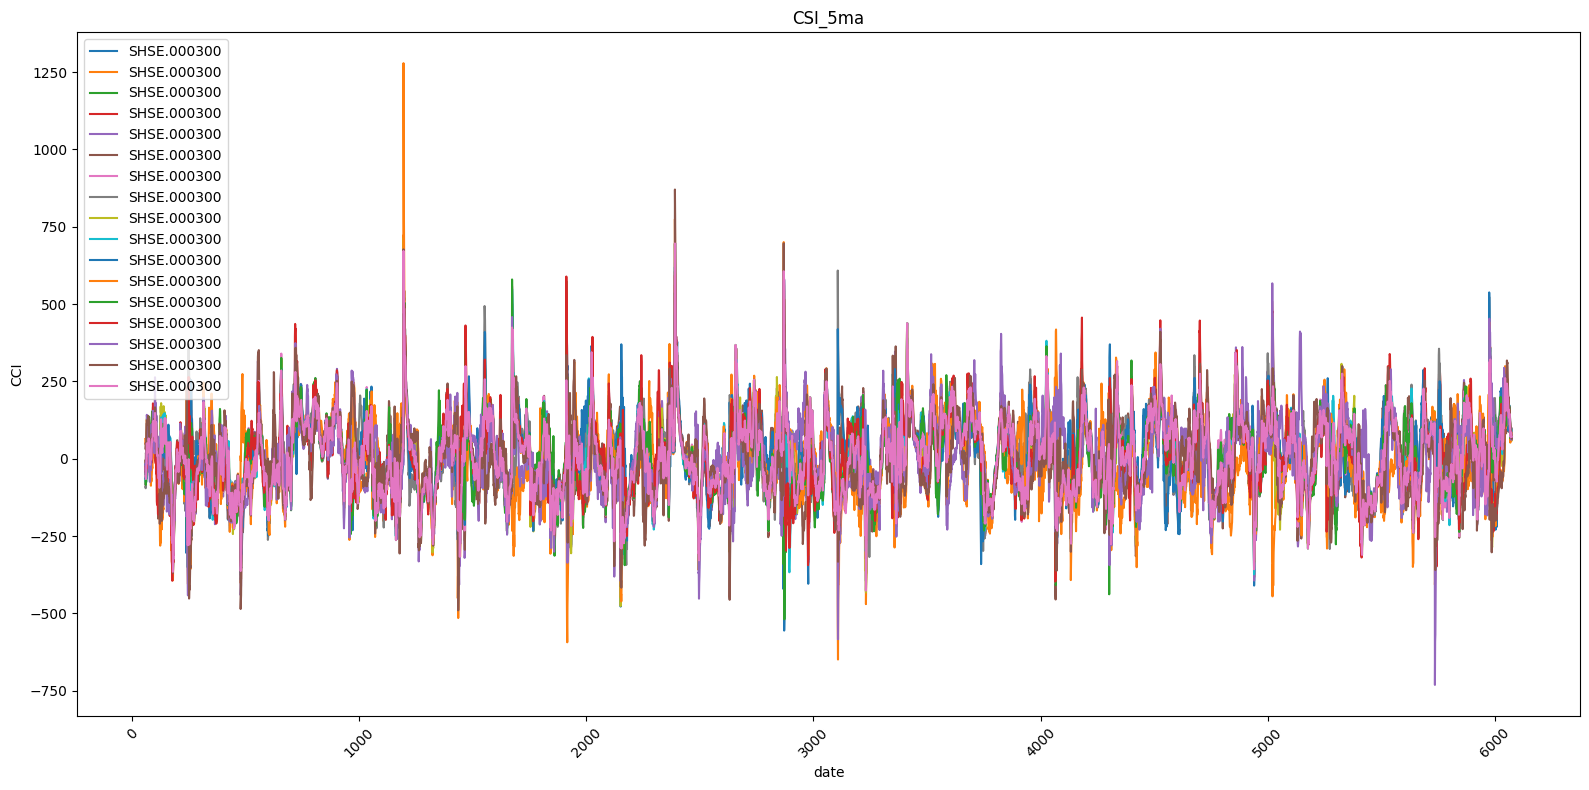

In [160]:
# 绘制所有股票的5日均线
plt.figure(figsize=(16, 8))

for i in range(17):
    # 确保日期列被识别为时间戳
    all_indicators[f'df_{i}_date'] = pd.to_datetime(all_indicators[f'df_{i}_date'])
    index_date = [_ for _ in range(len(all_indicators[f'df_{i}_date']))]
    plt.plot(index_date[50:-50], all_indicators[f'df_{i}_CCI'][50:-50], label=code)

plt.title('CSI_5ma')
plt.xlabel('date')
plt.ylabel('CCI')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
zhishu_klines[code]
# 定义通用函数
def calculate_indicator(df, t=30, ma_period=5):
    """
    计算核心指标公式
    :param df: 包含['close', 'low', 'high']的DataFrame
    :param t: LLV/HHV周期
    :param ma_period: 移动平均周期
    :return: 添加计算结果的DataFrame
    """
    df = df.copy()
    # 计算LLV和HHV
    df['LLV'] = df['low'].rolling(window=t).min()
    df['HHV'] = df['high'].rolling(window=t).max()
    
    # 计算核心公式
    df['indicator'] = 100 * (df['close'] - df['LLV']) / (df['HHV'] - df['LLV'])
    df['indicator_ma'] = df['indicator'].rolling(window=ma_period).mean()
    return df

In [ ]:
# 计算各品种指标
T = 30  # 统一周期参数
indicators=[]
for code in zhishu:
    indicators.append(calculate_indicator(zhishu_klines[code], t=T, ma_period=5))


In [ ]:
type(indicators[0])

In [ ]:
# 合并所有指标
all_indicators = pd.concat(indicators, axis=1,keys=[f'df_{i}' for i in range(len(indicators))])
all_indicators.columns = [f'{code}_{col}' for code, col in all_indicators.columns]

In [158]:
all_indicators

,df_0_code,df_0_date,df_0_open,df_0_high,df_0_low,df_0_close,df_0_volume,df_0_LLV,df_0_HHV,df_0_indicator,...,df_16_LLV,df_16_HHV,df_16_indicator,df_16_indicator_ma,df_16_TYP,df_16_MA_TYP,df_16_AVEDEV,df_16_CCI,df_16_CCI_EMA,df_16_CCI_Signal
0,SHSE.000001,2025-01-09 09:31:00+08:00,3220.720,3220.804,3209.640,3213.522,1.708718e+09,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5038.751333,NaN,NaN,NaN,NaN,0
1,SHSE.000001,2025-01-09 09:32:00+08:00,3213.223,3215.152,3212.115,3215.152,8.386750e+08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5033.348000,NaN,NaN,NaN,NaN,0
2,SHSE.000001,2025-01-09 09:33:00+08:00,3214.972,3218.105,3214.018,3217.499,6.224165e+08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5035.665333,NaN,NaN,NaN,NaN,0
3,SHSE.000001,2025-01-09 09:34:00+08:00,3217.344,3217.344,3215.243,3216.173,4.907095e+08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5034.025333,NaN,NaN,NaN,NaN,0
4,SHSE.000001,2025-01-09 09:35:00+08:00,3215.738,3215.861,3212.881,3213.204,4.851267e+08,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5032.862000,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6120,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3970.453,3981.048,28.872109,20.173667,5298.016000,5296.753428,4.442685,18.946084,15.577691,0
6121,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3970.453,3981.048,47.192072,24.747522,5300.604000,5296.815833,4.498850,56.135333,42.616119,0
6122,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3970.453,3981.048,30.825861,29.755545,5300.055000,5296.921928,4.486582,46.554702,45.241841,0
6123,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3970.453,3981.048,38.131194,34.157622,5299.324000,5296.948461,4.509577,35.118426,38.492898,0


In [ ]:
# 计算CCI指标（以当前标的为例）
def calculate_cci(df, ma_period=60, ema_period=2):
    """
    计算CCI指标
    :param df: 包含OHLC的DataFrame
    :param ma_period: 移动平均周期
    :param ema_period: EMA平滑周期
    """
    # 计算典型价格
    condition1 = ((df['high'] > df['close']) & (df['close'] > df['open'])) | \
                 ((df['high'] > df['open']) & (df['open'] >= df['close']))
    part1 = np.where(condition1, df['close'], df['high'])
    
    condition2 = ((df['low'] < df['close']) & (df['close'] < df['open'])) | \
                 ((df['low'] < df['open']) & (df['open'] <= df['close']))
    part2 = np.where(condition2, df['close'], df['low'])
    
    df['TYP'] = part1 + part2 / 3
    
    # 计算移动平均
    df['MA_TYP'] = df['TYP'].rolling(window=ma_period).mean()
    
    # 计算平均绝对偏差
    def avedev(series):
        return np.mean(np.abs(series - series.mean()))
    
    df['AVEDEV'] = df['TYP'].rolling(window=ma_period).apply(avedev)
    
    # 计算CCI
    df['CCI'] = (df['TYP'] - df['MA_TYP']) / (0.015 * df['AVEDEV'])
    df['CCI_EMA'] = df['CCI'].ewm(span=ema_period, adjust=False).mean()
    return df

In [ ]:
print((all_indicators))

In [ ]:
ccis = []
for i in range(len(indicators)):
    cci = calculate_cci(indicators[i])
    cci['CCI_Signal'] = np.where(cci['CCI_EMA'] < -150, 1, 0)
    ccis.append(cci)

In [ ]:
cciss = pd.concat(ccis, axis=1,keys=[f'df_{i}' for i in range(len(ccis))])
cciss

In [ ]:
cciss

In [ ]:
mydata = cciss[('df_0', 'date')]
mydata
print(zhishu)

In [ ]:
mydata = cciss[[('df_0', 'date'),('df_0', 'CCI_Signal'),('df_1', 'CCI_Signal'),('df_2', 'CCI_Signal'),('df_3', 'CCI_Signal'),('df_4', 'CCI_Signal'),('df_5', 'CCI_Signal'),('df_6', 'CCI_Signal'),\
               ('df_7', 'CCI_Signal'),('df_8', 'CCI_Signal'),('df_9', 'CCI_Signal'),\
               ('df_10', 'CCI_Signal'),('df_11', 'CCI_Signal'),('df_12', 'CCI_Signal'),('df_13', 'CCI_Signal'),('df_14', 'CCI_Signal'),('df_15', 'CCI_Signal'),('df_16', 'CCI_Signal')]]

In [ ]:
mydata

In [ ]:
c1 = (cciss[('df_0', 'CCI_Signal')] == 1)
c2 = (cciss[('df_1', 'CCI_Signal')] == 1)
c3 = (cciss[('df_2', 'CCI_Signal')] == 1)

In [ ]:
zzz = cciss[c1 & c2 & c3]
zdate = zzz[("df_0","date")]

In [ ]:
zdate

In [ ]:
# 输出关键数据
print("最新指标值：")
print(all_indicators.iloc[-1])
print("\nCCI信号：", cci['CCI_Signal'].iloc[-1])

In [ ]:
# 可视化示例
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(all_indicators[0], label='上证50指标')
plt.plot(all_indicators[1], label='中盘指标')
plt.plot(all_indicators[2], label='深证成指指标')
plt.title('多指标分析')
plt.legend()
plt.show()

In [ ]:
renders[0]